In [10]:
import cPickle as pickle
import itertools
import json
import scipy as sp
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import time
from functools import partial
from operator import itemgetter

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, linear_model

import matplotlib.pyplot as plt

%matplotlib inline

## 1. Load Prediction of test data and CV-predictoin of train data

In [11]:
path_to_results = 'C:/Users/HZ/Dropbox/Bio_Physics_JailBreak/Kaggle/Final Prediction+/'


test_ID = pickle.load(open(path_to_results+'xtest_ID.pkl','rb'))    
y = pickle.load(open(path_to_results+'ytrain2.dat','rb'))  # ground-truth label of training data
print(y.shape)

results=['sgd_0p771702_wl_',
         'sgd_0p770356_wl_','sgd_0p769531_wl_',
         'svm-0p752773_wl_',
         "rf-335_","rf-all_",
         "xgb-665_","xgb-933_","xgb-all_","xgb_0p770751_wl_",
        "xgb_lr_0p777824_wl_","xgb_lr_0p777125_50Segments_wl_","xgb_lr_0p776415_wl_",
         "xgb_0p784886_wl_","xgb_0p785604_wl_","xgb_0p785120_wl_","xgb_0p784916_wl_",
        "xgb_0p785155_wl_","xgb_0p785468_wl_","xgb_0p785787_wl_","xgb_0p785890_wl_","xgb_0p786040_wl_","xgb_0p786290_wl_",
        "xgbmeta_0p793611_wl_",
        "xgbmeta_0p793971_wl_"]

# addition models
model_name1  = 'xgb_Oct192015134751_AUC_0p787695_sl_'
model_name2  = 'xgb_Oct192015065533_AUC_0p787632_sl_'
model_name3  = 'xgb_Oct192015133017_AUC_0p787608_sl_'
model_name4  = 'xgb_Oct192015101525_AUC_0p787437_sl_'
model_name5  = 'xgb_Oct192015120324_AUC_0p787252_sl_'
model_name6  = 'xgb_Oct192015085532_AUC_0p787197_sl_'
model_name7  = 'xgb_Oct192015040605_AUC_0p786733_sl_'
model_name8  = 'xgb_Oct192015051026_AUC_0p786338_sl_'
model_name9  = 'xgb_Oct192015120134_AUC_0p785606_sl_'
model_name10 = 'xgb_Oct192015052747_AUC_0p781263_sl_'
model_name11 = 'xgb_Oct192015065922_AUC_0p780004_sl_'
model_name12 = 'xgb_Oct192015154017_AUC_0p787790_sl_'
model_name13 = 'meta_xgb_Oct192015184228_AUC_0p794324_sl_'
model_name14 = 'meta_xgb_Oct192015184936_AUC_0p794619_sl_'
model_name15 = 'meta_xgb_Oct192015185918_AUC_0p794108_sl_'

model_saifeng=[model_name1,model_name2,model_name3,model_name4,model_name5,
               model_name6,model_name7,model_name8,model_name9,model_name10,
               model_name11,model_name12,model_name13,model_name14,model_name15]
results.extend(model_saifeng)

nameypreds_train = 'ypredtrain.pkl'
nameypreds_test = 'ypredtest.pkl'

preds_train=[]
preds_test =[]

for i, model in enumerate(results):
    ypred_train = list(pickle.load(open(path_to_results + model + nameypreds_train, 'rb')))
    print('Model-%d: The AUC score for model %s is: %f\n'%(i+1, model,metrics.roc_auc_score(y, ypred_train)))
    preds_train.append(ypred_train)
    preds_test.append(list(pickle.load(open(path_to_results + model + nameypreds_test, 'rb'))))
        
preds_train=np.array(preds_train).T
preds_test=np.array(preds_test).T    
print(preds_train.shape, preds_test.shape)

(145231L,)
Model-1: The AUC score for model sgd_0p771702_wl_ is: 0.771702

Model-2: The AUC score for model sgd_0p770356_wl_ is: 0.770356

Model-3: The AUC score for model sgd_0p769531_wl_ is: 0.769532

Model-4: The AUC score for model svm-0p752773_wl_ is: 0.752773

Model-5: The AUC score for model rf-335_ is: 0.770027

Model-6: The AUC score for model rf-all_ is: 0.768094

Model-7: The AUC score for model xgb-665_ is: 0.772898

Model-8: The AUC score for model xgb-933_ is: 0.773977

Model-9: The AUC score for model xgb-all_ is: 0.760597

Model-10: The AUC score for model xgb_0p770751_wl_ is: 0.770751

Model-11: The AUC score for model xgb_lr_0p777824_wl_ is: 0.777824

Model-12: The AUC score for model xgb_lr_0p777125_50Segments_wl_ is: 0.777126

Model-13: The AUC score for model xgb_lr_0p776415_wl_ is: 0.776415

Model-14: The AUC score for model xgb_0p784886_wl_ is: 0.784887

Model-15: The AUC score for model xgb_0p785604_wl_ is: 0.785604

Model-16: The AUC score for model xgb_0p78512

In [12]:
class ModelEnsembler(object):
    """
    Implement stacking to combine several models.
    1. BaggingEnsembler: take the simple average of level-0 predictions on the test set
    2. LSEnsembler: linear regression to minimize the least square lost of a linear combination of model predictions on the train set. 
             the optimized coefficients are used to combine model predictions on the test set.             
    """
    def __init__(self,generalizer=None):
        self.coef_ = 0
        
    # 1. BaggingEnsembler   
    def Bagging(self, preds_test):  # preds_test in the form of N x M, N: # of samples, M: # of level-0 model preds.
        return np.mean(preds_test, axis=1)   # average over M model preds
    
    # 2. LSEnsembler
    def fit_LS(self, X, y): # X = preds_train in the form of N x M
        self.coef_ = sp.optimize.nnls(X, y)[0] #argmin_w||Xw-y||_2 solver for w
        self.coef_ = np.array(map(lambda x: x/sum(self.coef_), self.coef_)) # normalized

    def predict_proba(self, X):  # X = preds_test in the form of N x M 
        return sp.dot(X, self.coef_)
    
    def score(self, y, ypreds):  # AUC score
        fpr, tpr, _ = roc_curve(y, ypreds)
        return auc(fpr, tpr)

In [13]:
# generate submission files
def save_results(test_ID, predictions, filename):
    """Given a vector of predictions, save results in CSV format."""
    with open(filename, 'w') as f:
        f.write("ID,target\n")
        for i in range(len(test_ID)):
            f.write("%d,%f\n" % (test_ID[i], predictions[i]))

## 2. Model Ensembling

### 2.0 Greedy Bagging with replacememnt

In [14]:
def greedy_bagging(preds_train, preds_test, y, nth=20):
    m,n = preds_train.shape
    bag_count=np.zeros(n) # to store the count of each model
    ytrain_accum = np.zeros(m) # to store the sum of selected ypred_train
    
    hist_auc=[]
    
    num_sel_models = 0
    best_auc = -9999
    
    true_best = -9999
    
    yauc = np.zeros(n)
    ytemp = np.zeros((m,n))
    
    while num_sel_models<nth:
        for i in range(n):
            ytemp[:,i] = (ytrain_accum*num_sel_models + preds_train[:,i])/float(num_sel_models+1)           
            yauc[i] = metrics.roc_auc_score(y, ytemp[:,i])
        
        max_ind = np.argmax(yauc)
        print('The best auc in round %d: %9.7f'%(num_sel_models,yauc[max_ind]))
        
        if yauc[max_ind]>true_best:
            true_best=yauc[max_ind]
            count_best=np.copy(bag_count)
                
        if yauc[max_ind]>best_auc*0.95:
            best_auc = yauc[max_ind]
            ytrain_accum = ytemp[:,max_ind]
            num_sel_models += 1
            bag_count[max_ind] += 1
            
            hist_auc.append(best_auc)
        else:
            break
    
    plt.gca()
    plt.plot(range(len(hist_auc)), hist_auc, 'ro--')
    plt.legend(loc='best',fontsize='medium')
    plt.xlabel('# of models')
    plt.ylabel('AUC score')
    plt.ylim([min(hist_auc) - .001, max(hist_auc) + .001])

    str1=time.strftime("%b%d%Y_%H%M%S", time.localtime())
    
    plt.savefig(path_to_results+'greedy-model-ensembling_'+str1+'.png')
    plt.show()
    
    return np.dot(preds_test,bag_count/float(num_sel_models)), bag_count, true_best, count_best,hist_auc

The best auc in round 0: 0.7946198
The best auc in round 1: 0.7956130
The best auc in round 2: 0.7956625
The best auc in round 3: 0.7957415
The best auc in round 4: 0.7957617
The best auc in round 5: 0.7957709
The best auc in round 6: 0.7957957
The best auc in round 7: 0.7958090
The best auc in round 8: 0.7958135
The best auc in round 9: 0.7958072
The best auc in round 10: 0.7957900
The best auc in round 11: 0.7957968
The best auc in round 12: 0.7958109
The best auc in round 13: 0.7958157
The best auc in round 14: 0.7958179
The best auc in round 15: 0.7958138
The best auc in round 16: 0.7958104
The best auc in round 17: 0.7958143
The best auc in round 18: 0.7958199
The best auc in round 19: 0.7958157


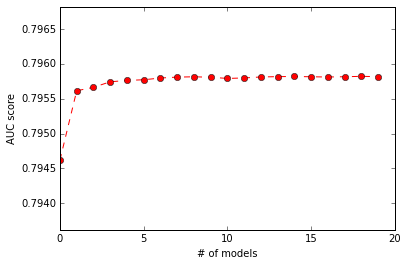

In [15]:
start_time=time.clock()

y_greedybag, bag_count, true_best, count_best,hist_auc = greedy_bagging(preds_train, preds_test, y, nth=20)

In [16]:
total_time=time.clock()-start_time
print('Completed Model Stacking')
print('Total running time is %d seconds\n' %total_time)

Completed Model Stacking
Total running time is 91 seconds



In [17]:
print('The best auc is %9.7f with greedy bagging and the model count is:'%true_best)
print(count_best)

The best auc is 0.7958199 with greedy bagging and the model count is:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  2.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  2.  7.  3.]


In [18]:
for i, model in enumerate(results):
    print('Model-%d: %s appears:'%(i+1, model))
    print('       %d times in final %d ensembles\n'%(count_best[i], count_best.sum()))

Model-1: sgd_0p771702_wl_ appears:
       0 times in final 18 ensembles

Model-2: sgd_0p770356_wl_ appears:
       0 times in final 18 ensembles

Model-3: sgd_0p769531_wl_ appears:
       0 times in final 18 ensembles

Model-4: svm-0p752773_wl_ appears:
       0 times in final 18 ensembles

Model-5: rf-335_ appears:
       0 times in final 18 ensembles

Model-6: rf-all_ appears:
       0 times in final 18 ensembles

Model-7: xgb-665_ appears:
       0 times in final 18 ensembles

Model-8: xgb-933_ appears:
       0 times in final 18 ensembles

Model-9: xgb-all_ appears:
       0 times in final 18 ensembles

Model-10: xgb_0p770751_wl_ appears:
       0 times in final 18 ensembles

Model-11: xgb_lr_0p777824_wl_ appears:
       0 times in final 18 ensembles

Model-12: xgb_lr_0p777125_50Segments_wl_ appears:
       0 times in final 18 ensembles

Model-13: xgb_lr_0p776415_wl_ appears:
       0 times in final 18 ensembles

Model-14: xgb_0p784886_wl_ appears:
       0 times in final 18 ensemb

In [19]:
count_best = np.array(count_best)
coef=count_best/float(count_best.sum())
print('The weight of models is:' )
print(coef)

yfinal = np.dot(preds_test, coef)

The weight of models is:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.11111111  0.22222222  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.11111111  0.38888889  0.16666667]


In [20]:
str1=time.strftime("%b%d%Y_%H%M%S", time.localtime())
outfile_greedy = path_to_results + 'ypred_modelensembling_greedy_'+str1+'.csv'

save_results(test_ID, yfinal, outfile_greedy)

### 2.1 Bagging

In [21]:
ME_BG = ModelEnsembler()
yme_BG = ME_BG.Bagging(preds_test)

### 2.2 Least-square

In [22]:
ME_LS = ModelEnsembler()
ME_LS.fit_LS(preds_train, y)
yme_LS = ME_LS.predict_proba(preds_test)

print('LS AUC: %9.7f with weight:'%metrics.roc_auc_score(y, ME_LS.predict_proba(preds_train)))
print(ME_LS.coef_)

LS AUC: 0.7957723 with weight:
[ 0.          0.          0.00871227  0.          0.          0.02898999
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.12279714  0.25077386  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.03925452  0.34698394  0.20248828]


### 2.3 Save Results for bagging and LS

In [23]:
str1=time.strftime("%b%d%Y_%H%M%S", time.localtime())
outfile_BG = path_to_results + 'ypred_modelensembling_bagging_'+str1+'.csv'
outfile_LS = path_to_results + 'ypred_modelensembling_leastsquare_'+str1+'.csv'

save_results(test_ID, yme_BG, outfile_BG)
save_results(test_ID, yme_LS, outfile_LS)